In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec
import glob
import netCDF4 as ncdf
from pynhhd import nHHD

import time

from datetime import datetime

# Local import 

from spectra.py_spectra import *


In [4]:
#-----------------------------------------------------------------
#
# This code can run and plot power spectra from a single day
#

def run_spectral_analysis(in_dir, out_dir, day, suffix_name = ["HRRR_ECONUS", "RRFS_ECONUS"], analysis_levels = [4, 18, 32]):
    

    hrrr_nhhd_file = str(os.path.join(in_dir, "%s_%s_hhd.nc" % (day, suffix_name[0])))
    rrfs_nhhd_file = str(os.path.join(in_dir, "%s_%s_hhd.nc" % (day, suffix_name[1])))
    
    hrrr_full_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[0])))
    rrfs_full_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[1])))
    
    print(hrrr_nhhd_file, hrrr_full_file)
    print(rrfs_nhhd_file, rrfs_full_file)
    
    # Open data sets

    hrrr_nhhd = xr.open_dataset(hrrr_nhhd_file) 
    rrfs_nhhd = xr.open_dataset(rrfs_nhhd_file)
    
    zlevels = hrrr_nhhd.z
    
    hrrr_full = xr.open_dataset(hrrr_full_file) 
    rrfs_full = xr.open_dataset(rrfs_full_file)

    # Loop over the analy_klevels to create multiple plots

    for k in analysis_levels:

        # these three levels are averaged together

        klevels = [k-1, k, k+1]

        # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

        hrrr_u  = np.nan_to_num(hrrr_full.u_interp.isel(nz=klevels).values).astype('float64')
        hrrr_v  = np.nan_to_num(hrrr_full.v_interp.isel(nz=klevels).values).astype('float64')
        hrrr_w  = np.nan_to_num(hrrr_full.w_interp.isel(nz=klevels).values).astype('float64')

        hrrr_ur = np.nan_to_num(hrrr_nhhd.ur.isel(nz=klevels).values).astype('float64')
        hrrr_vr = np.nan_to_num(hrrr_nhhd.vr.isel(nz=klevels).values).astype('float64')
        
        hrrr_ud = np.nan_to_num(hrrr_nhhd.ud.isel(nz=klevels).values).astype('float64')
        hrrr_vd = np.nan_to_num(hrrr_nhhd.vd.isel(nz=klevels).values).astype('float64')
        
        rrfs_u  = np.nan_to_num(rrfs_full.u_interp.isel(nz=klevels).values).astype('float64')
        rrfs_v  = np.nan_to_num(rrfs_full.v_interp.isel(nz=klevels).values).astype('float64')
        rrfs_w  = np.nan_to_num(rrfs_full.w_interp.isel(nz=klevels).values).astype('float64')

        rrfs_ur = np.nan_to_num(rrfs_nhhd.ur.isel(nz=klevels).values).astype('float64')
        rrfs_vr = np.nan_to_num(rrfs_nhhd.vr.isel(nz=klevels).values).astype('float64')

        rrfs_ud = np.nan_to_num(rrfs_nhhd.ud.isel(nz=klevels).values).astype('float64')
        rrfs_vd = np.nan_to_num(rrfs_nhhd.vd.isel(nz=klevels).values).astype('float64')
         
        # Compute spectra...

        fig = plt.figure(constrained_layout=True,figsize=(20,10))

        if k < 8:
            ylim = [1.0e2,1.0e8]
        else:
            ylim = [1.0e2,1.0e8]
            
        func    = get_spectra2D_DCT
        detrend = True

        gs = gridspec.GridSpec(1, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])

        plot_spectra(rrfs_u, varray=rrfs_v, func=func, ax=ax1, detrend=detrend, linecolor='r', linewidth=2.0, ylim=ylim, label='HRRR Hor. KE', ylabels=ylim[0])  
        plot_spectra(hrrr_u, varray=hrrr_v, func=func, ax=ax1, detrend=detrend, linecolor='k', linewidth=2.0 ,ylim=ylim, label='RRFS Hor. KE', ylabels=ylim[0])

        plot_spectra(rrfs_ur, varray=rrfs_vr, func=func, ax=ax1, detrend=detrend, linecolor='r', linewidth=1.0,  ylim=ylim, label='RRFS Hor. Rot. KE', ylabels=ylim[0])      
        plot_spectra(rrfs_ud, varray=rrfs_vd, func=func, ax=ax1, detrend=detrend, linecolor='g', linestyle='--', ylim=ylim, label='RRFS Hor. Div. KE', ylabels=ylim[0]) 
        
        plot_spectra(hrrr_ur, varray=hrrr_vr, func=func, ax=ax1, detrend=detrend, linecolor='k', linewidth=1.0,  ylim=ylim, label='HRRR Hor. Rot. KE', ylabels=ylim[0])
        plot_spectra(hrrr_ud, varray=hrrr_vd, func=func, ax=ax1, detrend=detrend, linecolor='b', linestyle='--', ylim=ylim, label='RRFS Hor. Div. KE', ylabels=ylim[0],
                     ptitle='Total/Rotational/Divergent KE',  LinsborgSlope=True)
        
        ax1.legend(loc='lower left', fontsize=16)
        
        ax1 = fig.add_subplot(gs[0, 1])
        
        if k < 8:
            ylim = [1.0e-1,1.0e6]
        else:
            ylim = [1.0e-1,1.0e6]
        
        plot_spectra(rrfs_w,  varray=rrfs_w, func=func, ax=ax1, detrend=detrend, linecolor='r', linewidth=2.0, ylim=ylim, label='RRFS W')      
        plot_spectra(hrrr_w,  varray=hrrr_w, func=func, ax=ax1, detrend=detrend, linecolor='k', linewidth=2.0, ylim=ylim, label='HRRR W', ylabels=ylim[0],
                     ptitle='W-KE Spectra', LinsborgSlope=False)
        
        ax1.legend(loc='lower left', fontsize=16)

        plt.suptitle("Total KE Avg Case Day %s \n Height Level: %3.1f km" % (day, zlevels[k]/1000.), fontsize=20)

        plt.savefig("%s/%s_Rotational and Divergent_KE_Spectra_%3.1fkm.png" % (out_dir, day, zlevels[k]/1000.),bbox_inches='tight', dpi=300)


Running day:  2022060700

/work/wicker/ECONUS/2022060700_HRRR_ECONUS_hhd.nc /work/wicker/ECONUS/2022060700_HRRR_ECONUS.nc
/work/wicker/ECONUS/2022060700_RRFS_ECONUS_hhd.nc /work/wicker/ECONUS/2022060700_RRFS_ECONUS.nc
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_DCT
plot_spectra: Spectrum computed for KE
plot_spectra: DETREND = True

          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 33

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_DCT is now being called


----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: 

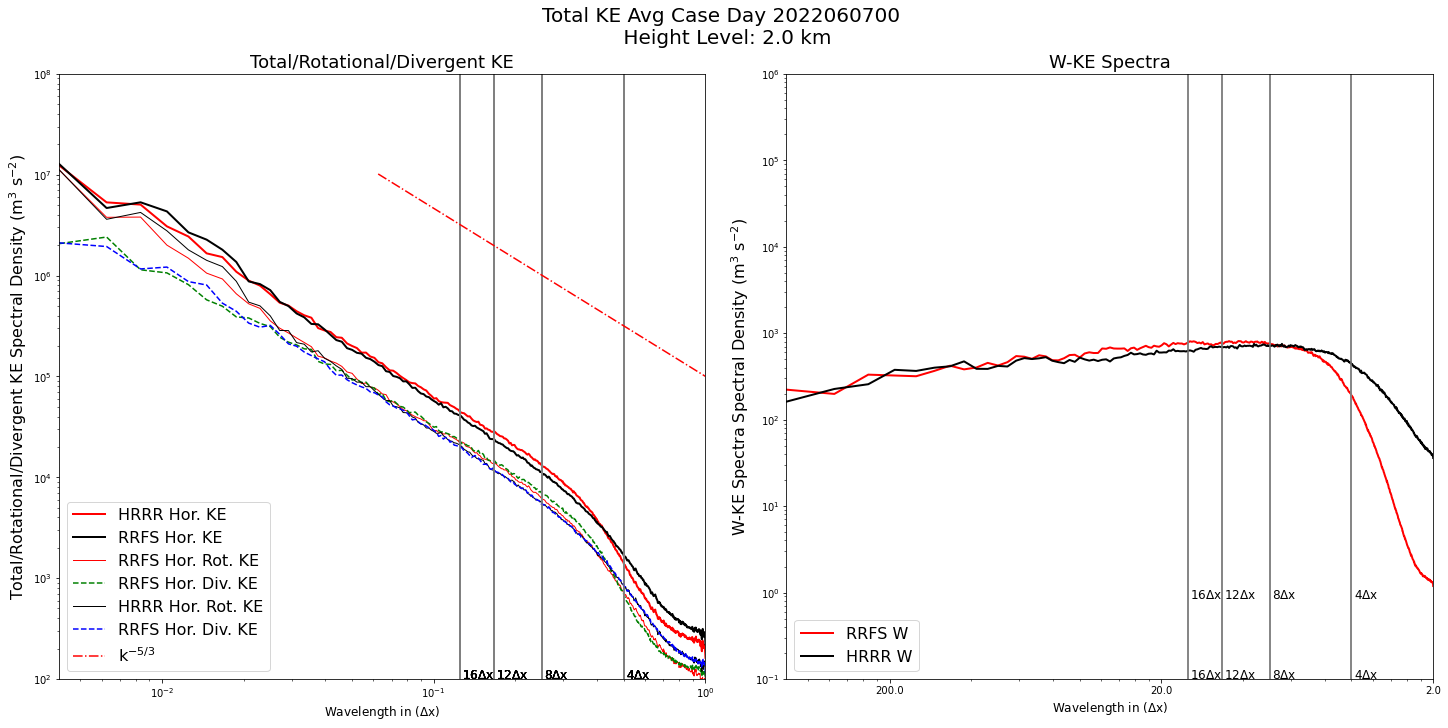

In [5]:
in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_new_spectra"

case_days = ["2022060700"]
#              "2022050400" 
#              "2022051200",
#              "2022051400",
#              "2022051500",
#              "2022051900",
#              "2022052300",
#              "2022052400",
#              "2022052700",
#              "2022053000",
#              "2022060700"]

#case_days = ["2022060700"]

for d in case_days:
    print("Running day:  %s\n" % d)
    #ret = run_spectral_analysis(in_dir, out_dir, d, analysis_levels = [4, 16, 28, 38])
    ret = run_spectral_analysis(in_dir, out_dir, d, analysis_levels = [4])
    

In [ ]:
import matplotlib.ticker as mticker

analysis_levels = [4, 16, 28, 38]

in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"

case_days = ["2022050400",
             "2022051200",
             "2022051400",
             "2022051500",
             "2022051900",
             "2022052300",
             "2022052400",
             "2022052700",
             "2022053000",
             "2022060700"]

#case_days = ["2022050400"]

ncases = len(case_days)

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

avg_rke = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}
avg_dke = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}
avg_tke = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}
avg_w   = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
           "RRFS":np.zeros((ncases,avg_grid.shape[0],))}

func   = get_spectra2D_DCT
dtrend = True
axis   = None

delta  = False

suffix_names = ["HRRR","RRFS"]
region       = "ECONUS"
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

for k in analysis_levels:
                
    # these levels are averaged together

    klevels = [k-1, k, k+1]

    for n, day in enumerate(case_days):
        
        for run in suffix_names:

            print("\n----> Processing run: %s for day:  %s \n" % (run, day))
            
            file1  = str(os.path.join(in_dir, "%s_%s_%s_hhd.nc" % (day, run, region)))
            print("          %s\n" % file1)
            
            file2  = str(os.path.join(in_dir, "%s_%s_%s.nc" % (day, run, region)))
            print("          %s\n" % file2)
            
            # Open data set

            ds = xr.open_dataset(file1)
            do = xr.open_dataset(file2)
            
            zlevels = ds.z
            
            print("                     K-LEVEL:  %d" % (k))

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            u  = np.nan_to_num(do.u_interp.isel(nz=klevels).values).astype('float64')
            v  = np.nan_to_num(do.v_interp.isel(nz=klevels).values).astype('float64')
            w  = np.nan_to_num(do.w_interp.isel(nz=klevels).values).astype('float64')

            ur = np.nan_to_num(ds.ur.isel(nz=klevels).values).astype('float64')
            vr = np.nan_to_num(ds.vr.isel(nz=klevels).values).astype('float64')

            ud = np.nan_to_num(ds.ud.isel(nz=klevels).values).astype('float64')
            vd = np.nan_to_num(ds.vd.isel(nz=klevels).values).astype('float64')

            # Compute rke spectra...

            ret = get_spectraND(ur, varrau=vr, func = func, dtrend = dtrend)

            avg_rke[run][n][:] = np.interp(avg_grid, ret[2], ret[1])

            # Compute dke spectra...

            ret = get_spectraND(ud, varrau=vd, func = func, dtrend = dtrend)

            avg_dke[run][n][:] = np.interp(avg_grid, ret[2], ret[1])

            # Compute tke spectra...

            ret = get_spectraND(u, varrau=v, func = func, dtrend = dtrend)

            avg_tke[run][n][:] = np.interp(avg_grid, ret[2], ret[1])

            # Compute w spectra...

            ret = get_spectraND(w, varrau=w, func = func, dtrend = dtrend)

            avg_w[run][n][:] = np.interp(avg_grid, ret[2], ret[1])

            ds.close()
            do.close()
            
    # Now average spectra over all the days...
    
    rke_hrrr = avg_rke['HRRR'].mean(axis=0)
    rke_rrfs = avg_rke['RRFS'].mean(axis=0)
    
    dke_hrrr = avg_dke['HRRR'].mean(axis=0)
    dke_rrfs = avg_dke['RRFS'].mean(axis=0)
           
    tke_hrrr = avg_tke['HRRR'].mean(axis=0)
    tke_rrfs = avg_tke['RRFS'].mean(axis=0)
    
    tke_hrrr = avg_tke['HRRR'].mean(axis=0)
    tke_rrfs = avg_tke['RRFS'].mean(axis=0)

    w_hrrr   = avg_w['HRRR'].mean(axis=0)
    w_rrfs   = avg_w['RRFS'].mean(axis=0)
   
    # Now plot the average spectra

    fig = plt.figure(constrained_layout=True,figsize=(20,10))

    gs = gridspec.GridSpec(1, 2, figure=fig)

    axes = fig.add_subplot(gs[0, 0])

    axes.loglog(avg_grid, rke_hrrr, color='black', linewidth=1., label='HRRR Hor. Rot. KE')
    axes.loglog(avg_grid, rke_rrfs, color='red',   linewidth=1., label='RRFS Hor. Rot. KE')
    
    axes.loglog(avg_grid, dke_hrrr, color='blue',  linestyle='--', label='HRRR Hor. Div. KE')
    axes.loglog(avg_grid, dke_rrfs, color='green', linestyle='--', label='RRFS Hor. Div. KE')
    
    axes.loglog(avg_grid, 10*tke_hrrr, color='black', linewidth=3., label='HRRR Hor. KE')
    axes.loglog(avg_grid, 10*tke_rrfs, color='red',   linewidth=3., label='RRFS Hor. KE')

    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)
    
    if k < 10:
        ylim = [1.0e1,1.0e7]
    else:
        ylim = [1.0e2,1.0e8]
        
    # Linsborg -5/3 slope
    
    xpt = [2.0/32.,2.0/2.0]
    dlnx = np.log(xpt[1]) - np.log(xpt[0])
    y1   = ylim[1]/(1000.)
    y0   = np.exp(np.log(y1) + 5./3. * dlnx)
    ypt  = [y0,y1]
    axes.loglog(xpt, ypt, color='red',linestyle='-.',label='k$^{-5/3}$')

    axes.set_ylim(ylim[0], ylim[1])
        
    axes.legend(loc="lower left",fontsize=16)
    
    axes.xaxis.set_major_formatter(lambda x, pos: str(int(2.0/x)))
        
    ylabel = 3*ylim[0]

    xoffset = [0.01, 0.005, 0.0035, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"E(k) Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)
    
    plt.title("Total (x10) / ROTATIONAL / DIVERGENT KE SPECTRA: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)
    
    # W-KE spectra
    
    axes = fig.add_subplot(gs[0, 1])

    axes.loglog(avg_grid, w_hrrr, color='black', linewidth=2., label='HRRR W')
    axes.loglog(avg_grid, w_rrfs, color='red',   linewidth=2., label='RRFS W')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.legend(loc="lower left", fontsize=18)
        
    #axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
    
    axes.xaxis.set_major_formatter(lambda x, pos: str(int(2.0/x)))

    if k < 8:
        ylim = [1.0e-1,1.0e4]
    else:
        ylim = [1.0e-1,1.0e4]
        
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 3*ylim[0]

    xoffset = [0.01, 0.005, 0.0035, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"E(k) Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    plt.title("W SPECTRA ALL: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)

    plt.savefig("%s/%s_%3.1fkm.png" % (out_dir, 'SPECTRA_2PANEL_DCT', zlevels[k]/1000.),bbox_inches='tight',dpi=300)




====> Begin processing runs


----> Processing run: HRRR for day:  2022050400 

          /work/wicker/ECONUS/2022050400_HRRR_ECONUS_hhd.nc

          /work/wicker/ECONUS/2022050400_HRRR_ECONUS.nc

                     K-LEVEL:  4
          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 18

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_DCT is now being called


          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 18

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_DCT is now being called


  